In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, cohen_kappa_score
from IPython.display import HTML, display
import itertools
import seaborn as sns
import math

In [2]:
df = []
for i in range(5):
    _df = pd.read_csv(f"./llama/human_eval/svolgimenti/65b_ps_df1/Svolgimenti_{i}.csv")
    _df["Questionario"] = f"human_eval_65b_ps_df1_{i}"
    df.append(_df)
df = pd.concat(df, axis=0)

In [3]:
_full_df = pd.read_csv("./llama/human_eval/svolgimenti/Svolgimenti_tutti.csv", index_col=0)

# remove extra quest
full_df = _full_df.loc[_full_df.Questionario != "human_eval_df1_5", :]

# sort data by questionary
full_df = full_df.sort_values(by="Questionario")

# answers to float
q_cols = [f"Domanda {i}" for i in range(1, 21)]
full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(
    lambda x: float(x.replace("Risposta ", "")) if type(x) == str else x
)

# indent signle missing value in human_eval_7b_ps_df1_3
quest_name = "human_eval_7b_ps_df1_3"
mean_val = full_df.set_index("Questionario").loc[quest_name, "Domanda 19"].mean()
mask = full_df.Questionario == quest_name
full_df.loc[mask, "Domanda 19"] = full_df.loc[mask, "Domanda 19"].fillna(mean_val)

full_df = full_df.reset_index(drop=True)
full_df = full_df.loc[full_df.Stato == "Completato", :]
full_df = full_df.loc[full_df.filter(regex="Domanda*").notna().all(axis=1), :]
full_df = full_df.loc[full_df.loc[:, "Domanda 7"] > 3, :]

/tmp/ipykernel_2736834/814033450.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(


In [4]:
mask_7b_pretrain = full_df.Questionario.str.contains("7b_ps")
mask_65b_pretrain = full_df.Questionario.str.contains("65b_ps")
mask_65b_finetune = full_df.Questionario.str.contains("65b_fts")
mask_7b_finetune = ~(mask_7b_pretrain | mask_65b_finetune | mask_65b_pretrain)

df_7b_pretrain = full_df.loc[mask_7b_pretrain, :].copy()
df_7b_pretrain.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_7b_pretrained_shorter/" +
    df_7b_pretrain.loc[:, "Questionario"].str.replace("7b_ps_", "") +
    ".csv"
)

df_7b_finetune = full_df.loc[mask_7b_finetune, :].copy()
df_7b_finetune.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_7b_fine_tuned_shorter/" +
    df_7b_finetune.loc[:, "Questionario"].str.replace("7b_ps_", "") +
    ".csv"
)

df_65b_pretrain = full_df.loc[mask_65b_pretrain, :].copy()
df_65b_pretrain.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_65b_pretrained_shorter/" +
    df_65b_pretrain.loc[:, "Questionario"].str.replace("65b_ps_", "") +
    ".csv"
)

df_65b_finetune = full_df.loc[mask_65b_finetune, :].copy()
df_65b_finetune.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_65b_fine_tuned_shorter/" +
    df_65b_finetune.loc[:, "Questionario"].str.replace("65b_fts_", "") +
    ".csv"
)

In [5]:
def normalize(x):
    return (x - x.mean()) / x.std()

def preprocess_df(df):
    background_dfs = [pd.read_csv(i, index_col=0) for i in df.Questionario.unique()]
    no_control_questions = []
    new_bkg_dfs = []
    for idx, background_df in enumerate(background_dfs):
        background_df.index = [f"Domanda {idx * 20 + i}" for i in range(1, 21)]
        no_control_questions.append([f"Domanda {idx * 20 + i}" for i in range(1, 21) if i != 7])
        background_df = background_df.loc[no_control_questions[idx], :]
        new_bkg_dfs.append(background_df)
    background_df = pd.concat(new_bkg_dfs, axis=0)

    _new_dfs = []
    _dfs = df.groupby("Questionario")
    _qs = []
    for idx, (q_name, _df) in enumerate(_dfs):
        _df = _df.filter(regex="Domanda*")
        _df = _df.rename({f"Domanda {i}": f"Domanda {idx * 20 + i}" for i in range(1, 21)}, axis=1)
        _df = _df.loc[:, no_control_questions[idx]]
        _df = _df.T
        _new_dfs.append(_df)
        for i in range(_df.shape[0]):
            _qs.append(q_name)
    _df = pd.concat(_new_dfs, axis=0)
    _df = pd.DataFrame([i[~np.isnan(i)][:5] for i in _df.values])
    _df.loc[:, "Questionario"] = _qs
    return _df, background_df

def get_metrics_df(_df, background_df):
    _metrics_df = pd.DataFrame()
    for col_idx, col in enumerate(_df.columns):
        if col == "Questionario":
            continue
        if _df.loc[:, col].notna().all():
            _metrics_df.loc[:, f"player {col_idx}"] = _df.loc[:, col].reset_index(drop=True)
    _metrics_df.loc[:, "avg_pred"] = _df.mean(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_pred"] = _metrics_df["avg_pred"] <= 3
    _metrics_df.loc[:, "bool_scaled_pred"] = _metrics_df["avg_pred"] <= _metrics_df["avg_pred"].mean()
    _metrics_df.loc[:, "high_pred"] = _df.max(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_high_pred"] = _metrics_df.high_pred <= 3
    _metrics_df.loc[:, "low_pred"] = _df.min(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_low_pred"] = _metrics_df.low_pred <= 3
    _metrics_df.loc[:, "bool_is_human"] = background_df.is_human.reset_index(drop=True)
    _metrics_df.loc[:, "is_human"] = _metrics_df["bool_is_human"].apply(int)
    _metrics_df.loc[:, "missed"] = _metrics_df["bool_scaled_pred"] != _metrics_df["is_human"]
    _metrics_df.loc[:, "catched"] = _metrics_df["bool_scaled_pred"] == _metrics_df["is_human"]
    _metrics_df.loc[:, "Questionario"] = _df.loc[:, "Questionario"].values
    return _metrics_df

def compute_acc(metrics_df):
    return (
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_scaled_pred"]), 3) * 100,
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_pred"]), 3) * 100,
    #    np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_high_pred"]), 3) * 100,
    #    np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_low_pred"]), 3) * 100,
    )

def compute_all_acc(metrics_df):
    n_players = metrics_df.filter(regex="player*").shape[1]
    all_cohens = []
    quest_scores = {}
    quest_scores["accuracy"] = {}
    scaled_mean, mean = compute_acc(metrics_df)
    quest_scores["accuracy"]["scaled mean"] = scaled_mean
    quest_scores["accuracy"]["mean"] = mean
    players_scores = {}
    all_metrics_df = metrics_df.groupby("Questionario")
    for idx, (_, metrics_df) in enumerate(all_metrics_df):
        players_scores[f"Chunk {idx}"] = {}
        quest_scores[f"Chunk {idx}"] = {}
        quest_x = []
        for i in range(n_players):
            acc = np.round(
                accuracy_score(
                    metrics_df.loc[:, f"bool_is_human"],
                    metrics_df.loc[:, f"player {i}"] <= 3.0
                ),
                3
            ) * 100
            quest_x.append(acc)
            players_scores[f"Chunk {idx}"][i] = {"accuracy": acc}
        all_data = np.zeros((n_players, n_players))
        for i, j in itertools.combinations(range(n_players), r=2):
            all_data[i,j] = cohen_kappa_score(
                metrics_df.loc[:, f"player {i}"] <= 3.0,
                metrics_df.loc[:, f"player {j}"] <= 3.0
            )
        all_cohens.append(all_data)
        scaled_mean, mean = compute_acc(metrics_df)
        quest_scores[f"Chunk {idx}"]["scaled mean"] = scaled_mean
        quest_scores[f"Chunk {idx}"]["mean"] = mean
    return quest_scores, players_scores, all_cohens

In [6]:
processed_pretrain_7b_df, background_pretrain_7b_df = preprocess_df(df_7b_pretrain)
pretrain_metrics_7b_df = get_metrics_df(processed_pretrain_7b_df, background_pretrain_7b_df)

processed_finetune_7b_df, background_finetune_7b_df = preprocess_df(df_7b_finetune)
finetune_metrics_7b_df = get_metrics_df(processed_finetune_7b_df, background_finetune_7b_df)

processed_pretrain_65b_df, background_pretrain_65b_df = preprocess_df(df_65b_pretrain)
pretrain_metrics_65b_df = get_metrics_df(processed_pretrain_65b_df, background_pretrain_65b_df)

processed_finetune_65b_df, background_finetune_65b_df = preprocess_df(df_65b_finetune)
finetune_metrics_65b_df = get_metrics_df(processed_finetune_65b_df, background_finetune_65b_df)

Chunk 0 {0: {'accuracy': 63.2}, 1: {'accuracy': 52.6}, 2: {'accuracy': 84.2}, 3: {'accuracy': 78.9}}
Chunk 1 {0: {'accuracy': 73.7}, 1: {'accuracy': 63.2}, 2: {'accuracy': 89.5}, 3: {'accuracy': 52.6}}
Chunk 2 {0: {'accuracy': 78.9}, 1: {'accuracy': 73.7}, 2: {'accuracy': 57.9}, 3: {'accuracy': 42.1}}
Chunk 3 {0: {'accuracy': 84.2}, 1: {'accuracy': 63.2}, 2: {'accuracy': 63.2}, 3: {'accuracy': 68.4}}
Chunk 4 {0: {'accuracy': 84.2}, 1: {'accuracy': 78.9}, 2: {'accuracy': 84.2}, 3: {'accuracy': 78.9}}


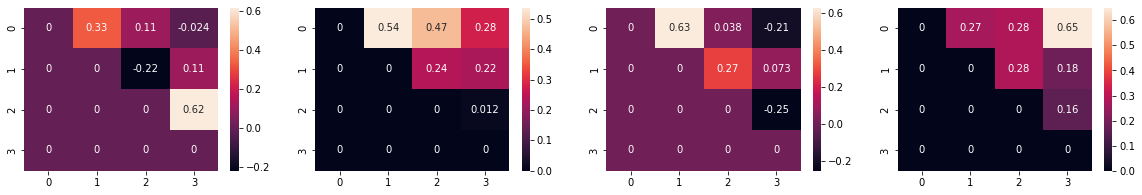

In [7]:
pretrain_7b_quest_scores, pretrain_7b_players_scores, pretrain_7b_all_cohens = compute_all_acc(pretrain_metrics_7b_df)
for key, val in pretrain_7b_players_scores.items():
    print(key, val)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        pretrain_7b_all_cohens[i],
        annot=True,
        ax=ax[i]
    )

In [8]:
pretrain_7b_quest_scores_df = pd.DataFrame.from_dict(pretrain_7b_quest_scores).reset_index(names="metric")
pretrain_7b_quest_scores_df.loc[:, "model"] = ["pretrain 7b" for _ in range(pretrain_7b_quest_scores_df.shape[0])]
pretrain_7b_quest_scores_df = pretrain_7b_quest_scores_df.set_index(["model", "metric"])
pretrain_7b_quest_scores_df

accuracy  Chunk 0  Chunk 1  Chunk 2  Chunk 3  Chunk 4
model       metric                                                            
pretrain 7b scaled mean      82.1     78.9     84.2     73.7     78.9     94.7
            mean             82.1     73.7     78.9     78.9     84.2     94.7

Chunk 0 {0: {'accuracy': 73.7}, 1: {'accuracy': 68.4}, 2: {'accuracy': 63.2}, 3: {'accuracy': 52.6}}
Chunk 1 {0: {'accuracy': 73.7}, 1: {'accuracy': 63.2}, 2: {'accuracy': 73.7}, 3: {'accuracy': 78.9}}
Chunk 2 {0: {'accuracy': 52.6}, 1: {'accuracy': 57.9}, 2: {'accuracy': 52.6}, 3: {'accuracy': 52.6}}
Chunk 3 {0: {'accuracy': 47.4}, 1: {'accuracy': 63.2}, 2: {'accuracy': 52.6}, 3: {'accuracy': 57.9}}
Chunk 4 {0: {'accuracy': 57.9}, 1: {'accuracy': 73.7}, 2: {'accuracy': 68.4}, 3: {'accuracy': 63.2}}


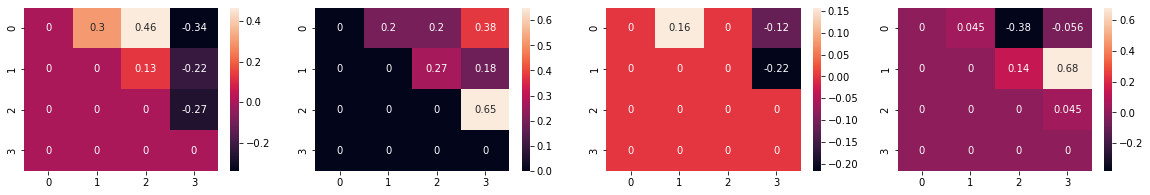

In [9]:
finetune_7b_quest_scores, finetune_7b_players_scores, finetune_7b_all_cohens = compute_all_acc(finetune_metrics_7b_df)
for key, val in finetune_7b_players_scores.items():
    print(key, val)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        finetune_7b_all_cohens[i],
        annot=True,
        ax=ax[i]
    )

In [10]:
finetune_7b_quest_scores_df = pd.DataFrame.from_dict(finetune_7b_quest_scores).reset_index(names="metric")
finetune_7b_quest_scores_df.loc[:, "model"] = ["finetune 7b" for _ in range(finetune_7b_quest_scores_df.shape[0])]
finetune_7b_quest_scores_df = finetune_7b_quest_scores_df.set_index(["model", "metric"])
finetune_7b_quest_scores_df

accuracy  Chunk 0  Chunk 1  Chunk 2  Chunk 3  Chunk 4
model       metric                                                            
finetune 7b scaled mean      73.7     78.9     84.2     63.2     63.2     78.9
            mean             69.5     68.4     84.2     47.4     73.7     73.7

Chunk 0 {0: {'accuracy': 63.2}, 1: {'accuracy': 73.7}, 2: {'accuracy': 73.7}}
Chunk 1 {0: {'accuracy': 78.9}, 1: {'accuracy': 57.9}, 2: {'accuracy': 63.2}}
Chunk 2 {0: {'accuracy': 68.4}, 1: {'accuracy': 57.9}, 2: {'accuracy': 57.9}}
Chunk 3 {0: {'accuracy': 63.2}, 1: {'accuracy': 63.2}, 2: {'accuracy': 63.2}}
Chunk 4 {0: {'accuracy': 63.2}, 1: {'accuracy': 63.2}, 2: {'accuracy': 73.7}}


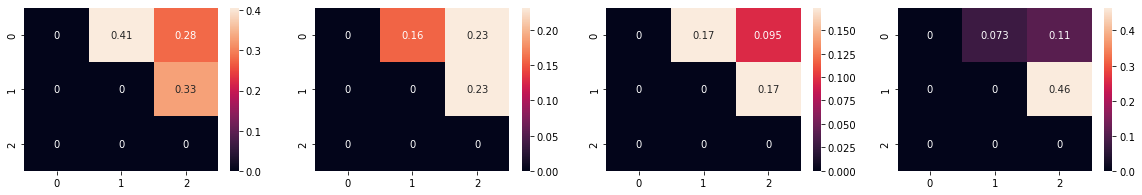

In [11]:
pretrain_65b_quest_scores, pretrain_65b_players_scores, pretrain_65b_all_cohens = compute_all_acc(pretrain_metrics_65b_df)
for key, val in pretrain_65b_players_scores.items():
    print(key, val)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        pretrain_65b_all_cohens[i],
        annot=True,
        ax=ax[i]
    )

In [12]:
pretrain_65b_quest_scores_df = pd.DataFrame.from_dict(pretrain_65b_quest_scores).reset_index(names="metric")
pretrain_65b_quest_scores_df.loc[:, "model"] = ["pretrain 65b" for _ in range(pretrain_65b_quest_scores_df.shape[0])]
pretrain_65b_quest_scores_df = pretrain_65b_quest_scores_df.set_index(["model", "metric"])
pretrain_65b_quest_scores_df

accuracy  Chunk 0  Chunk 1  Chunk 2  Chunk 3  \
model        metric                                                      
pretrain 65b scaled mean      73.7     78.9     73.7     78.9     68.4   
             mean             72.6     68.4     84.2     73.7     68.4   

                          Chunk 4  
model        metric                
pretrain 65b scaled mean     68.4  
             mean            68.4

Chunk 0 {0: {'accuracy': 52.6}, 1: {'accuracy': 57.9}, 2: {'accuracy': 26.3}, 3: {'accuracy': 42.1}}
Chunk 1 {0: {'accuracy': 57.9}, 1: {'accuracy': 63.2}, 2: {'accuracy': 52.6}, 3: {'accuracy': 73.7}}
Chunk 2 {0: {'accuracy': 63.2}, 1: {'accuracy': 63.2}, 2: {'accuracy': 63.2}, 3: {'accuracy': 36.8}}
Chunk 3 {0: {'accuracy': 63.2}, 1: {'accuracy': 73.7}, 2: {'accuracy': 47.4}, 3: {'accuracy': 52.6}}
Chunk 4 {0: {'accuracy': 73.7}, 1: {'accuracy': 73.7}, 2: {'accuracy': 63.2}, 3: {'accuracy': 78.9}}


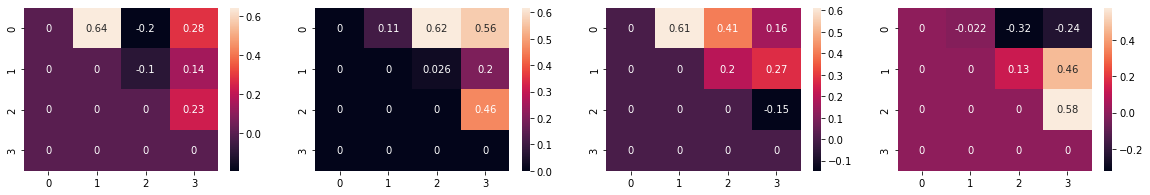

In [13]:
finetune_65b_quest_scores, finetune_65b_players_scores, finetune_65b_all_cohens = compute_all_acc(finetune_metrics_65b_df)
for key, val in finetune_65b_players_scores.items():
    print(key, val)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        finetune_65b_all_cohens[i],
        annot=True,
        ax=ax[i]
    )

In [14]:
finetune_65b_quest_scores_df = pd.DataFrame.from_dict(finetune_65b_quest_scores).reset_index(names="metric")
finetune_65b_quest_scores_df.loc[:, "model"] = ["finetune 65b" for _ in range(finetune_65b_quest_scores_df.shape[0])]
finetune_65b_quest_scores_df = finetune_65b_quest_scores_df.set_index(["model", "metric"])

In [15]:
full_scores_df = pd.concat(
    [
        pretrain_7b_quest_scores_df,
        finetune_7b_quest_scores_df,
        pretrain_65b_quest_scores_df,
        finetune_65b_quest_scores_df
    ],
    axis=0
)
print(full_scores_df.style.format(precision=1).to_latex(hrules=True))

\begin{tabular}{llrrrrrr}
\toprule
 &  & accuracy & Chunk 0 & Chunk 1 & Chunk 2 & Chunk 3 & Chunk 4 \\
model & metric &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{pretrain 7b} & scaled mean & 82.1 & 78.9 & 84.2 & 73.7 & 78.9 & 94.7 \\
 & mean & 82.1 & 73.7 & 78.9 & 78.9 & 84.2 & 94.7 \\
\multirow[c]{2}{*}{finetune 7b} & scaled mean & 73.7 & 78.9 & 84.2 & 63.2 & 63.2 & 78.9 \\
 & mean & 69.5 & 68.4 & 84.2 & 47.4 & 73.7 & 73.7 \\
\multirow[c]{2}{*}{pretrain 65b} & scaled mean & 73.7 & 78.9 & 73.7 & 78.9 & 68.4 & 68.4 \\
 & mean & 72.6 & 68.4 & 84.2 & 73.7 & 68.4 & 68.4 \\
\multirow[c]{2}{*}{finetune 65b} & scaled mean & 65.3 & 36.8 & 73.7 & 63.2 & 68.4 & 84.2 \\
 & mean & 63.2 & 52.6 & 63.2 & 57.9 & 57.9 & 84.2 \\
\bottomrule
\end{tabular}

